In [6]:
import sys
import os

current_dir = os.path.dirname(os.path.abspath(''))
others_path = os.path.join(current_dir, '..', 'gpr')

others_path = os.path.abspath(others_path)
if others_path not in sys.path:
    sys.path.append(others_path)

import numpy as np
import matplotlib.pyplot as plt
from collections.abc import Callable
import cvxpy as cp

from eos import EosProperties
from kernels import Kernel
import gaussianprocess
import finitedimensionalgp
import sampling as sam
import prepare_ceft as pc
import prepare_pqcd as pp
import anal_helpers as anal
from pqcd.pQCD import pQCD
from constants import get_phi, ns
import virtobs as vo

from pathlib import Path
notebook_dir = Path.cwd()

from scipy.linalg import cholesky, solve_triangular, cho_solve
from scipy.stats import norm
import scipy as sp
import pandas as pd


from aquarel import load_theme
theme = (
        load_theme("gruvbox_dark")
        .set_font("serif")
        .set_grid(True, width=0.2)
        )

theme.apply()

In [19]:
n_ceft, cs2_ceft, cs2_l, cs2_u = anal.get_ceft_cs2()
cs2_ceft_sigma = pc.CI_to_sigma(cs2_u-cs2_l)
cs2_hat, X_hat, sigma_hat, l_hat, alpha_hat = sam.get_hype_samples()
n_pqcd, cs2_pqcd = pp.get_pqcd(X_hat, size=400)
cs2_pqcd_sigma = np.zeros_like(cs2_pqcd)



indices = np.arange(0, len(n_ceft), 1)
n = np.concatenate((n_ceft[indices], n_pqcd))
cs2 = np.concatenate((cs2_ceft[indices], cs2_pqcd))
cs2_sigma = np.concatenate((cs2_ceft_sigma[indices], cs2_pqcd_sigma))

x_test = np.linspace(n_ceft[0], 10, 400) # number density in nsat, starting val is ending val of n crust, ending val is default 10 nsat

In [25]:
kernel = Kernel('SE', sigma=sigma_hat, l=l_hat)


m = 500

fdgp = finitedimensionalgp.FDGP(kernel, n, cs2, x_test, cs2_sigma, cs2_hat, True, m=m, sampling=False)

constr = fdgp.set_constraints(m=fdgp.m, constraint_type='boundedness', l = 0, u=1, rm_inf=True)

constr_cs2 = fdgp.compute_MAP()

samples = fdgp.sample_posterior(1,return_trace=False)

Optimization terminated successfully    (Exit mode 0)
            Current function value: -1700272299.8679276
            Iterations: 1
            Function evaluations: 1
            Gradient evaluations: 1


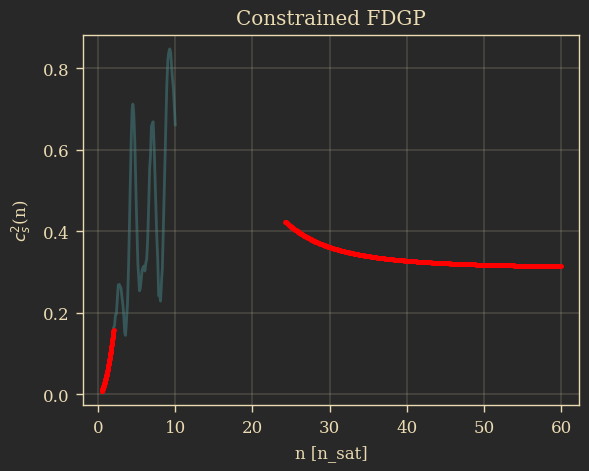

In [26]:
sample = samples[0]  # shape (fdgp.m,)
phi_matrix = np.array([fdgp._phi_j(j, fdgp.x_test[:, None]) for j in range(fdgp.m)])  # shape (fdgp.m, len(x_test))
cs2_constrained = phi_matrix.T @ sample
for i in range(0, samples.shape[0]):
    plt.plot(x_test, cs2_constrained[i], alpha = 0.5)
plt.plot(n, cs2, 'r.', markersize=5, label='Observations')
plt.xlabel('n [n_sat]')
plt.ylabel(r'$c_s^2$(n)')
plt.title("Constrained FDGP")
plt.show()


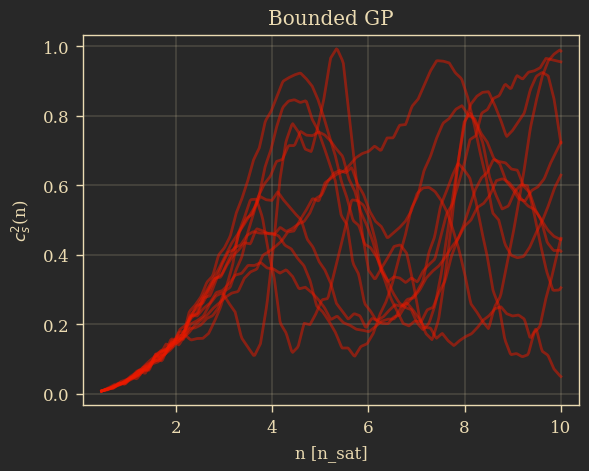

In [12]:
for i in range(10):
    n_ceft, cs2_ceft, cs2_l, cs2_u = anal.get_ceft_cs2()
    cs2_ceft_sigma = pc.CI_to_sigma(cs2_u-cs2_l)
    cs2_hat, X_hat, sigma_hat, l_hat, alpha_hat = sam.get_hype_samples()
    n_pqcd, cs2_pqcd = pp.get_pqcd(X_hat, size=400)
    cs2_pqcd_sigma = np.zeros_like(cs2_pqcd)



    indices = np.arange(0, len(n_ceft), 1)
    n = np.concatenate((n_ceft[indices], n_pqcd))
    cs2 = np.concatenate((cs2_ceft[indices], cs2_pqcd))
    cs2_sigma = np.concatenate((cs2_ceft_sigma[indices], cs2_pqcd_sigma))

    x_test = np.linspace(n_ceft[0], 10, 400) # number density in nsat, starting val is ending val of n crust, ending val is default 10 nsat
    kernel = Kernel('SE', sigma=sigma_hat, l=l_hat)
    m = 500

    fdgp = finitedimensionalgp.FDGP(kernel, n, cs2, x_test, cs2_sigma, cs2_hat, True, m=m, sampling=True)

    constr = fdgp.set_constraints(m=fdgp.m, constraint_type='boundedness', l = 0, u=1, rm_inf=True)

    constr_cs2 = fdgp.compute_MAP()

    samples = fdgp.sample_posterior(1, burn_in=100, return_trace=False)
    sample = samples[0]  # shape (fdgp.m,)
    phi_matrix = np.array([fdgp._phi_j(j, fdgp.x_test[:, None]) for j in range(fdgp.m)])  # shape (fdgp.m, len(x_test))
    cs2_constrained = phi_matrix.T @ sample

    plt.plot(x_test, cs2_constrained[0], alpha = 0.5, color='#ea1900')

plt.xlabel('n [n_sat]')
plt.ylabel(r'$c_s^2$(n)')
plt.title("Bounded GP")
plt.show()

In [4]:
filename = "/home/sam/thesis/code/results/nmma/SE_10ns_1/data/GW170817_data_dump.pickle"

import re

with open(filename, "rb") as f:
    raw = f.read()

# Extract all floats from the pickle bytes
floats = re.findall(rb"[-+]?\d*\.\d+(?:[eE][-+]?\d+)?", raw)
float_values = [float(x) for x in floats]

# Show the most negative ones (likely evidence estimates)
negatives = sorted([v for v in float_values if v < 0])
print("Most negative values found (candidates for logZ):")
for v in negatives[:20]:
    print(v)


Most negative values found (candidates for logZ):
-8.2
-0.9
-0.9
-0.9
-0.8
-0.8
-0.7
-0.7
-0.7
-0.7
-0.6
-0.6
-0.6
-0.6
-0.6
-0.5
-0.5
-0.5
-0.5
-0.35
